<a href="https://colab.research.google.com/github/ShaneRSmyth/Sentinel-1_and_2_and_MarineBuoy/blob/main/Initial_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [ ]:
!pip install spyndex

In [ ]:
!pip install rasterio

In [ ]:
!pip install geemap

In [ ]:
!pip install folium

In [ ]:
!pip install tifffile

In [ ]:
!pip install imagecodecs

In [ ]:
!pip install georasters

# Libraries

In [ ]:
import folium
import ee, eemont
import geemap
import geemap.colormaps as cm
import spyndex
import rasterio
import folium

# Authenticate

In [ ]:
ee.Authenticate()

# Sentinel-2 NDWI (works)

In [ ]:
import ee
import folium
import os
import geemap

# initialize Earth Engine
ee.Initialize()

# latitude, longitude
roi = ee.Geometry.Point(-6.704336, 51.690425)

# start and end dates
start_date = '2023-09-29T00:00:00Z'
end_date = '2023-10-02T00:00:00Z'

# sentinel 2 image collection with specified time and region of interest
s2_collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate(ee.Date(start_date), ee.Date(end_date)) \
    .filterBounds(roi) \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first()

# near-Infrared (NIR) and Green (B3) bands
nir_band = 'B8'
green_band = 'B3'

# NDWI
ndwi = s2_collection.normalizedDifference([nir_band, green_band])

# this is where the exported image gets saved
output_folder = '/content/drive/MyDrive/Sentinel2_NDWI'

# interactive map to visualize
Map = geemap.Map(center=[51.690425, -6.704336], zoom=10)

# adding ndwi layer to the interactive map
Map.addLayer(ndwi, {'min': -1, 'max': 1, 'palette': ['0000FF', '00FF00']}, 'NDWI')

# export to google drive
task = ee.batch.Export.image.toDrive(
    image=ndwi, #specify image to export
    description='NDWI_Image', # specify file name
    folder=output_folder, #specify folder location
    fileNamePrefix='ndwi_image', # prefix
    scale=10,  # 10m resolution
    maxPixels=120604324 # entire region
)

# start export
task.start()
# debug export
print(task.status())

# start the interactive map
Map


# Sentinel-1 SAR VV (works)

In [ ]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

# Define a region of interest (ROI) as a point (latitude, longitude)
# Define a larger ROI as a bounding box
roi = ee.Geometry.Rectangle([-7.0, 51.5, -6.5, 52.0])


# Define the time period (start and end dates) for the image collection
start_date = '2023-01-01T00:00:00Z'
end_date = '2023-01-04T00:00:00Z'

# Create a Sentinel-1 image collection for the specified time period and ROI
s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate(ee.Date(start_date), ee.Date(end_date)) \
    .filterBounds(roi) \
    .first()
    # .sort('CLOUDY_PIXEL_PERCENTAGE')

# Select the VV polarization band for visualization
vv_band = s1_collection.select('VV')

# Convert the bands to Float32 data type
s1_collection = s1_collection.toFloat()

# Create a map centered on the ROI
map_center = roi.coordinates().reverse().getInfo()
Map = geemap.Map(center=map_center, zoom=10)

vis_params = {
    'min': -30,    # Adjust the min and max values based on your data range
    'max': 5,
    'palette': ['navy', 'lightblue', 'darkblue'],  # Customize the palette for ocean features
}

# Add the SAR imagery to the map
Map.addLayer(vv_band, vis_params, 'SAR Image')
#  {
#     # 'bands': ['VV'],
#     'min': -30,
#     'max': 0,
#     # 'gamma': 1.4
# }, 'SAR Image')

# Export SAR image to Google Drive
export_params = {
    'image': vv_band,
    'description': 'SAR_Image_4',
    'fileFormat': 'GeoTIFF',
    'folder': '/content/drive/MyDrive/Sentinel1_SAR',  # Replace with your Google Drive folder path
    'scale': 10,  # Adjust scale as needed
    'region': roi
}

# Start the export task
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

# Wait for the export task to complete (optional)
task.status()

taskCheck = ee.batch.Task.list()
print(taskCheck)

# Display the map
Map


# Sentinel-1 SAR VV and VH (works)

In [ ]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

# Define a region of interest (ROI) as a point (latitude, longitude)
# Define a larger ROI as a bounding box
roi = ee.Geometry.Rectangle([-7.0, 51.5, -6.5, 52.0])

# Define the time period (start and end dates) for the image collection
start_date = '2023-01-01'
end_date = '2023-01-04'

# Create a Sentinel-1 image collection for the specified time period and ROI
s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate(ee.Date(start_date), ee.Date(end_date)) \
    .filterBounds(roi)

# Select one image from the collection
s1_image = ee.Image(s1_collection.first())

# Convert the selected image to Float32 data type
s1_image = s1_image.toFloat()

# Create a map centered on the ROI
map_center = roi.coordinates().reverse().getInfo()
Map = geemap.Map(center=map_center, zoom=10)

# Define visualization parameters for VV and VH bands
vv_vis_params = {
    'min': -30,    # Adjust the min and max values based on your data range
    'max': 5,
    'palette': ['navy', 'lightblue', 'darkblue'],  # Customize the palette for ocean features
}

# Add the VV band to the map with its visualization parameters
Map.addLayer(s1_image.select('VV'), vv_vis_params, 'VV Band')

# Define visualization parameters for VH band
vh_vis_params = {
    'min': -30,    # Adjust the min and max values based on your data range
    'max': 5,
    'palette': ['green', 'lightgreen', 'darkgreen'],  # Customize the palette for VH band
}

# Add the VH band to the map with its visualization parameters
Map.addLayer(s1_image.select('VH'), vh_vis_params, 'VH Band')

# Export the selected SAR image to Google Drive
export_params = {
    'image': s1_image,
    'description': 'SAR_Image_5',
    'fileFormat': 'GeoTIFF',
    'folder': '/content/drive/MyDrive/Sentinel1_SAR',  # Replace with your Google Drive folder path
    'scale': 10,  # Adjust scale as needed
    'region': roi
}

# Start the export task
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

# Wait for the export task to complete (optional)
task.status()

taskCheck = ee.batch.Task.list()
print(taskCheck)

# Display the map
Map


# Rasterio NDWI Pre-processing

In [ ]:
# Visualizing Exported Sentinel-2 NDWI Image using Rasterio instead of QGIS

import rasterio
import matplotlib.pyplot as plt

# Path to your NDWI TIFF file
ndwi_tif_path = '/content/drive/MyDrive/Sentinel2_NDWI/ndwi_image.tif'
with rasterio.open(ndwi_tif_path) as src:
    # Access metadata
    metadata = src.meta
    crs = src.crs
    bounds = src.bounds
    transform = src.transform
    num_bands = src.count
    band_names = src.descriptions

# Print metadata
print("Metadata:")
print(metadata)

# Print CRS (Coordinate Reference System) information
print("\nCRS:")
print(crs)

# Print spatial bounds
print("\nBounds:")
print(bounds)

# Print geotransformation matrix
print("\nTransform:")
print(transform)

# Print number of bands and their names
print("\nNumber of bands:", num_bands)
print("Band names:", band_names)

# Open the NDWI TIFF file using rasterio
ndwi_dataset = rasterio.open(ndwi_tif_path)

# Read the NDWI image data as an array
ndwi_image = ndwi_dataset.read(1)  # Assuming it's a single-band image

# Plot the NDWI image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(ndwi_image, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust the colormap and limits as needed
plt.colorbar(label='NDWI Value')
plt.title('NDWI Image')
plt.axis('off')  # Turn off axis labels
plt.show()


# Alignment

In [ ]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point

# Load CSV data with WGS84 coordinates (EPSG-4326)
csv_data = gpd.GeoDataFrame(pd.read_csv('/content/drive/MyDrive/Sentinel1_SAR/M5_Buoy_Data_2023_01_01.csv', usecols=['latitude', 'longitude']))
# After the transformation, add the following lines to print the first few rows
print(csv_data.head())

# Define the target CRS (EPSG-32629 for UTM zone 29N)
target_crs = 'EPSG:32629'

# Create a coordinate transformer
transformer = pyproj.Transformer.from_crs('EPSG:4326', target_crs, always_xy=True)

# Convert WGS84 coordinates to EPSG-32629
csv_data['geometry'] = csv_data.apply(lambda row: Point(transformer.transform(row['longitude'], row['latitude'])), axis=1)
csv_data.crs = target_crs

# Load SAR image
with rasterio.open('/content/drive/MyDrive/Sentinel2_NDWI/ndwi_image.tif') as src:
    sar_data = src.read(1)  # Adjust the band number if needed

# Create a scatter plot of the CSV data points
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of CSV data points
ax.scatter(csv_data['geometry'].x, csv_data['geometry'].y, c='red', label='CSV Data', marker='o')

# Overlay the SAR image to visually check alignment
ax.imshow(sar_data, cmap='gray', extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top), alpha=0.5, label='SAR Image')

plt.legend()
plt.show()


# Linear Regression (Works)

Coefficients: [-4.09450019e-07]
Intercept: 10.980963081636006


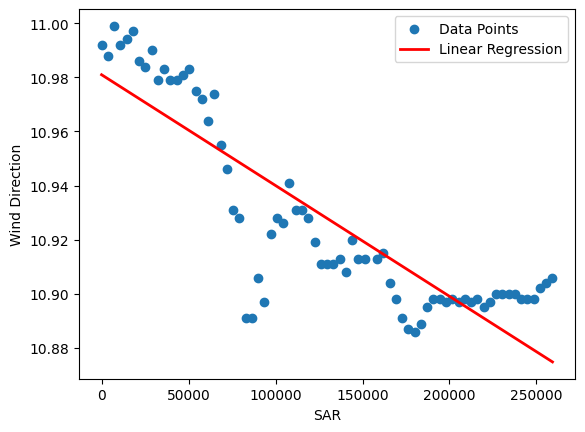

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from osgeo import gdal
import matplotlib.pyplot as plt

# Load the TIFF file using GDAL
tif_path = '/content/drive/MyDrive/ content drive MyDrive Sentinel1_SAR/SAR_Image_1.tif'
ds = gdal.Open(tif_path)
ndwi_data = ds.ReadAsArray()

# Load the CSV file using pandas
csv_path = '/content/drive/MyDrive/Sentinel1_SAR/M5_Buoy_Data_2023_01_01.csv'
csv_data = pd.read_csv(csv_path)

# Remove rows with NaN values from the CSV data
csv_data = csv_data.dropna(subset=['SeaTemperature'])

# Extract NDWI values for the corresponding rows in the CSV data
ndwi_values = []
for index, row in csv_data.iterrows():
    x, y = int(row['longitude']), int(row['latitude'])  # Adjust column names as needed
    ndwi_value = ndwi_data[y, x]
    ndwi_values.append(ndwi_value)

X_ndwi = np.array(ndwi_values).reshape(-1, 1)
y = csv_data['SeaTemperature'].values

# Convert Timestamps to Unix Timestamps (tz-naive)
csv_data['time'] = pd.to_datetime(csv_data['time']).dt.tz_localize(None)
csv_data['time'] = (csv_data['time'] - pd.Timestamp("2023-01-01")).dt.total_seconds()

# Merge Data on Timestamps
merged_data = csv_data[['time', 'SeaTemperature']].copy()
merged_data['NDWI'] = X_ndwi

# Perform Linear Regression
model = LinearRegression()
X_timestamp = merged_data['time'].values.reshape(-1, 1)
model.fit(X_timestamp, y)

# Print coefficients and intercept of the linear regression model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Create a scatter plot of the data points
plt.scatter(X_timestamp, y, label='Data Points')

# Generate points along the regression line for plotting
x_line = np.linspace(X_timestamp.min(), X_timestamp.max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)

# Plot the regression line
plt.plot(x_line, y_line, color='red', linewidth=2, label='Linear Regression')

# Add labels and a legend
plt.xlabel('SAR')
plt.ylabel('Wind Direction')
plt.legend()

# Show the plot
plt.show()
